# Enron Scandal: Indentifying Person of Interest

Identify Enron employees who may have committed fraud based on the public [Enron financial dataset from Udacity](https://github.com/udacity/ud120-projects/tree/master/final_project)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper

sns.set()
np.random.seed(9)

## Load and prepare the data

In [2]:
data_path = 'data/enron_financial_data.pkl'
df = pd.read_pickle(data_path)
df = pd.DataFrame.from_dict(df, orient='index')
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,63014,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


### Explore and Clean the target

In [3]:
print(df['poi'].squeeze().value_counts(dropna=False))

False    128
True      18
Name: poi, dtype: int64


** Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve **

### Preprocess the data

In [4]:
# delete email adresses feature (the only non-numerical)
if 'email_address' in df.columns:
    df.drop('email_address', axis='columns', inplace=True)

# delete 'TOTAL' row (at the bottom)
if 'TOTAL' in df.index:
    df.drop('TOTAL', axis='index', inplace=True) 

# convert dataframe values to numerical
df = df.apply(pd.to_numeric, errors='coerce')

# Reeplace NaN values with the median
df.fillna(df.median(), inplace=True)

df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,2000000.0,4175000.0,-126027.0,-3081055.0,1729541.0,13868.0,47.0,1729541.0,2195.0,152.0,65.0,False,304805.0,1407.0,126027.0,106164.5
BADUM JAMES P,258741.0,1211.0,178980.0,182466.0,2000000.0,750000.0,-140264.0,-151927.0,257817.0,3486.0,35.0,257817.0,41.0,51984.5,8.0,False,422158.0,740.5,441096.0,106164.5
BANNANTINE JAMES M,477.0,566.0,221063.5,916197.0,2000000.0,750000.0,-560222.0,-5104.0,5243487.0,56301.0,39.0,4046157.0,29.0,864523.0,0.0,False,422158.0,465.0,1757552.0,106164.5
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,2000000.0,1200000.0,-140264.0,-1386055.0,10623258.0,11200.0,35.0,6680544.0,41.0,2660303.0,8.0,False,1586055.0,740.5,3942714.0,106164.5
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,2000000.0,400000.0,-82782.0,-201641.0,63014.0,129142.0,35.0,1297049.0,41.0,69.0,8.0,False,422158.0,740.5,145796.0,106164.5


Target: **poi** =  person of interest (boolean)

In [5]:
# print(df.dtypes)
df.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,1.450000e+02,145.000000,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,1.450000e+02,145.000000,145.000000,1.450000e+02,145.000000,1.450000e+02,145.000000,1.450000e+02,145.000000,1.450000e+02,145.000000
mean,2.751726e+05,1722.765517,3.836875e+05,2.402823e+06,2.537414e+06,1.002370e+06,-5.090768e+04,-2.939814e+05,3.040758e+06,51503.251724,52.731034,2.455073e+06,377.758621,3.142113e+05,27.710345,5.675487e+05,999.072414,9.720599e+05,104361.286207
std,1.428664e+05,2029.355094,7.086025e+05,8.785497e+06,6.606451e+06,1.097890e+06,1.305242e+06,5.750959e+05,6.112358e+06,37235.033251,68.431460,4.646612e+06,1441.885356,1.122664e+06,78.611644,5.976139e+05,930.455922,1.972272e+06,14229.056893
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-1.787380e+06,-3.504386e+06,-4.409300e+04,148.000000,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3285.000000
25%,2.396710e+05,904.000000,2.210635e+05,5.511740e+05,2.000000e+06,7.000000e+05,-1.402640e+05,-1.519270e+05,5.974610e+05,33785.000000,25.000000,7.573010e+05,36.000000,2.630000e+03,6.000000,4.221580e+05,589.000000,3.605280e+05,106164.500000
50%,2.587410e+05,1211.000000,2.210635e+05,1.100246e+06,2.000000e+06,7.500000e+05,-1.402640e+05,-1.519270e+05,1.095040e+06,46547.500000,35.000000,1.297049e+06,41.000000,5.198450e+04,8.000000,4.221580e+05,740.500000,4.410960e+05,106164.500000
75%,2.690760e+05,1607.000000,2.210635e+05,1.934359e+06,2.000000e+06,8.000000e+05,-1.402640e+05,-1.519270e+05,2.282768e+06,53122.000000,41.000000,1.668260e+06,52.000000,1.504580e+05,14.000000,4.221580e+05,900.000000,6.989200e+05,106164.500000
max,1.111258e+06,15149.000000,6.426990e+06,1.035598e+08,8.152500e+07,8.000000e+06,1.545629e+07,-8.330000e+02,4.911008e+07,228763.000000,528.000000,3.434838e+07,14368.000000,1.035973e+07,609.000000,5.145434e+06,5521.000000,1.476169e+07,137864.000000


### Visualize the data

(0, 50000000.0)

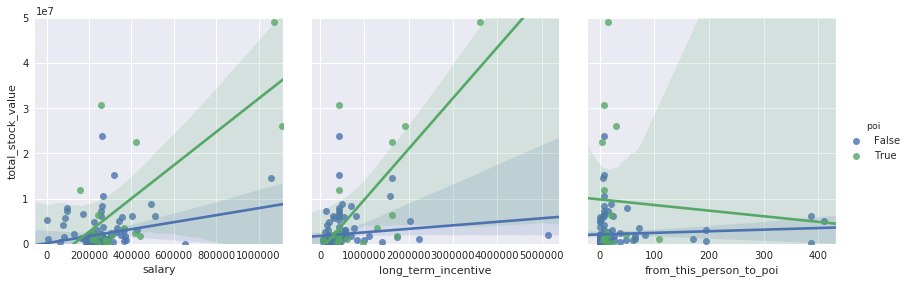

In [6]:
# df.plot.scatter(x='salary', y='total_stock_value')
# df.plot.scatter(x='long_term_incentive', y='total_stock_value')

# sns.lmplot(x="salary", y="total_stock_value", hue='poi', data=df)
# sns.lmplot(x="long_term_incentive", y="total_stock_value", hue='poi', data=df)

g = sns.PairGrid(df, y_vars=["total_stock_value"], x_vars=["salary", "long_term_incentive", "from_this_person_to_poi"], hue='poi',size=4)
g.map(sns.regplot).add_legend()
plt.ylim(ymin=0, ymax=0.5e8)

#sns.pairplot(df, hue='poi', vars=['long_term_incentive', 'total_stock_value', 'from_poi_to_this_person'], kind='reg', size=3)

The person of interest seems to have a higher stock vs salary and long term incentive, especially when his stock value is high, but no more emails from or to other person of interest are appreciated.

### Tune selected features
Fast way to remove features before training the model


In [7]:
fields_to_drop = []
data = df.drop(fields_to_drop, axis=1)
# filtered dataset now in 'data'

### Scale numerical features

In [8]:
# here all the features except for target 'poi' are continuous variable
quant_features = list(data.drop('poi', axis=1)) 

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for f in quant_features:
    mean, std = data[f].mean(), data[f].std()
    scaled_features[f] = [mean, std]
    data.loc[:, f] = (data[f] - mean)/std

data.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,-0.512490,0.581088,3.508356,0.236938,-0.081347,2.889753,-0.057552,-4.846276,-0.214519,-1.010748,-0.083749,-0.156142,1.260323,-0.279745,0.474353,False,-0.439655,0.438417,-0.428963,0.126728
BADUM JAMES P,-0.115013,-0.252181,-0.288889,-0.252730,-0.081347,-0.229868,-0.068460,0.247010,-0.455297,-1.289572,-0.259106,-0.472873,-0.233554,-0.233575,-0.250731,False,-0.243285,-0.277899,-0.269214,0.126728
BANNANTINE JAMES M,-1.922744,-0.570016,-0.229500,-0.169214,-0.081347,-0.229868,-0.390207,0.502312,0.360373,0.128850,-0.200654,0.342418,-0.241877,0.490184,-0.352497,False,-0.243285,-0.573990,0.398268,0.126728
BAXTER JOHN C,-0.056490,-0.252181,1.287112,0.367824,-0.081347,0.180009,-0.068460,-1.898942,1.240520,-1.082401,-0.259106,0.909366,-0.233554,2.089754,-0.250731,False,1.704288,-0.277899,1.506209,0.126728
BAY FRANKLIN R,-0.248495,-0.252181,-0.173909,-0.179287,-0.081347,-0.548662,-0.024420,0.160565,-0.487168,2.085099,-0.259106,-0.249219,-0.233554,-0.279819,-0.250731,False,-0.243285,-0.277899,-0.418940,0.126728


### Split the data into training and test sets

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df,  test_size=0.3, random_state=9)

# Separate the data into features and targets (x=features, y=targets)
target = ['poi']
x_train, y_train_nc = train.drop(target, axis=1).values, train[target].values
x_test, y_test_nc = test.drop(target, axis=1).values, test[target].values
# _nc: non-categorical yet

# no validation set; categorical_crossentropy will be used here

### Encode the output

In [10]:
import keras

# One-hot encoding the output 
num_classes = 2
y_train = keras.utils.to_categorical(y_train_nc, num_classes)
y_test = keras.utils.to_categorical(y_test_nc, num_classes)
print("Training set: \t x-shape = {} \t y-shape = {}".format(x_train.shape ,y_train.shape))
print("Test set: \t x-shape = {} \t y-shape = {}".format(x_test.shape ,y_test.shape))

Using TensorFlow backend.


Training set: 	 x-shape = (101, 19) 	 y-shape = (101, 2)
Test set: 	 x-shape = (44, 19) 	 y-shape = (44, 2)


### Dummy classifier

In [11]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc


def scores(y_test, y_pred):
    """ Print  different scores """
    
    print()
    print('Accuracy: \t{:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: \t{:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: \t{:.2f}'.format(recall_score(y_test, y_pred)))
    print('\n Confusion matrix: \n', confusion_matrix(y_test, y_pred))

In [12]:
from sklearn.dummy import DummyClassifier

# Negative class (0) is most frequent
%time clf = DummyClassifier(strategy='most_frequent').fit(x_train, np.ravel(y_train))
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_pred = clf.predict(x_test).reshape([-1, 1])

scores(y_test[:,1], y_pred)
print('\n\n ROC AUC test: \t{:.2f} \n'.format(roc_auc_score(y_test[:,1], y_pred)))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 231 µs

Accuracy: 	0.84
Precision: 	0.00
Recall: 	0.00

 Confusion matrix: 
 [[37  0]
 [ 7  0]]


 ROC AUC test: 	0.50 



/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Deep Neural Network
  

In [13]:
from sklearn.utils import class_weight

y_plain = np.ravel(y_train[:,1])

cw = class_weight.compute_class_weight('balanced', np.unique(y_plain), y_plain)

cw = {idx : value for idx, value in enumerate(cw)}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 19)                380       
_________________________________________________________________
dropout_1 (Dropout)          (None, 19)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
Epoch 00048: early stopping


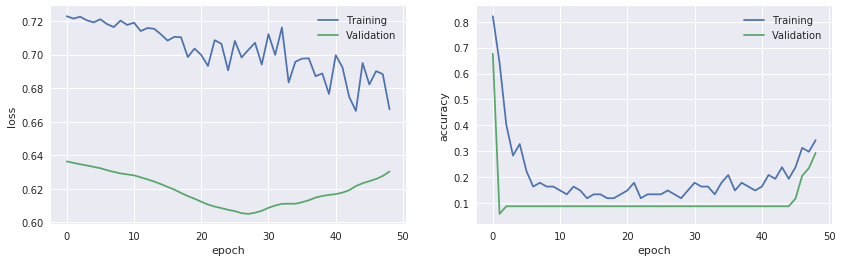


Training loss:  	0.6674
Validation loss: 	0.6303

Training accuracy: 	0.343
Validation accuracy:	0.294


In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout

nodes = x_train.shape[1]

weights = keras.initializers.RandomNormal(stddev=0.00001)

model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation='relu',
               kernel_initializer=weights,
               bias_initializer = 'zero'))
model.add(Dropout(.5))
model.add(Dense(2,activation='softmax',
               kernel_initializer = weights,
               bias_initializer = 'zero'))


# opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
opt = keras.optimizers.adam(lr=0.000001)
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)]
history = model.fit(x_train, y_train, epochs=200, batch_size=32, verbose=0, 
                    validation_split = 0.33, callbacks=callbacks, class_weight = cw)

helper.show_training(history)


### Evaluate the model

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {:.4f}".format(score[1]))

Accuracy: 0.2955


In [17]:
y_pred = model.predict(x_test, verbose=1)[:,1]
print('\n\n Neural Network ROC AUC test: \t{:.2f} \n'.format(roc_auc_score(y_test[:,1], y_pred)))
scores(y_test[:,1], (y_pred>0.5).astype(int))

32/44 [====================>.........] - ETA: 0s

 Neural Network ROC AUC test: 	0.77 


Accuracy: 	0.30
Precision: 	0.18
Recall: 	1.00

 Confusion matrix: 
 [[ 6 31]
 [ 0  7]]
